In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import norm
import scipy.constants as scp
from scipy.integrate import quad
from tabulate import tabulate
from scipy import signal
import scipy.constants as const

In [2]:
def sigma(x, y, dx, dy, label):
    s = np.abs(x-y)/np.sqrt(dx**2 + dy**2)
    print('Sigmaabweichung {} ='.format(str(label)), s)
    return s

---

# Induktionsgesetz

In [3]:
m1_I = 4 #A
m1_dI = 0.1

m1_f = np.array([4.1, 6, 9, 11.9, 14.8]) #Hz
m1_df = np.concatenate([np.full(2, 0.2), np.full(3, 0.1)])

m1_U = np.array([1.6,3.2,5.3,7.5,9.7]) #V
m1_dU = np.array([0.1,0.2,0.3,0.2,0.2])

m2_f = 9.9 #Hz
m2_df = 0.1

m2_I = 0.5 * np.arange(1,10) #A
m2_dI = np.full(9, 0.05)

m2_U = np.array([0.9,1.7,2.4,3.1,3.8,4.6,5.2,5.9,6.7]) #V
m2_dU = np.array([0.1,0.1,0.2,0.2,0.2,0.2,0.2,0.1,0.1])

In [4]:
#Fits
def linfit(x,a,b):
    return a*x+b

In [5]:
m1_pop, m1_cov = curve_fit(linfit, m1_f, m1_U, sigma=m1_dU, absolute_sigma=True)
m2_pop, m2_cov = curve_fit(linfit, m2_I, m2_U, sigma=m2_dU, absolute_sigma=True)

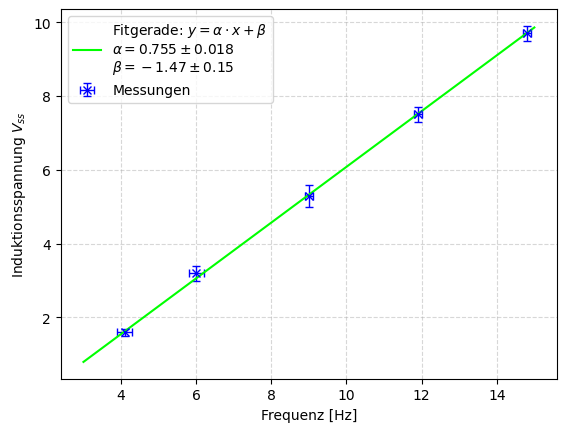

In [6]:
X = np.linspace(3, 15, 100)

plt.figure()
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(m1_f, m1_U, yerr=m1_dU, xerr=m1_df, color='blue', fmt='x', label='Messungen', capsize=3, lw=1)
plt.plot(X, linfit(X, *m1_pop), color='lime', 
        label="\n".join([r"Fitgerade: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.3f}\pm{:.2}$'.format(m1_pop[0], np.sqrt(m1_cov[0][0])), 
                          r'$\beta ={:.2f}\pm{:.2}$'.format(m1_pop[1], np.sqrt(m1_cov[1][1]))]))
plt.xlabel('Frequenz [Hz]')
plt.ylabel(r'Induktionsspannung $V_{ss}$')
plt.legend()
plt.savefig('./plots/Induktionsgesetz_U(f).pdf', format='PDF')

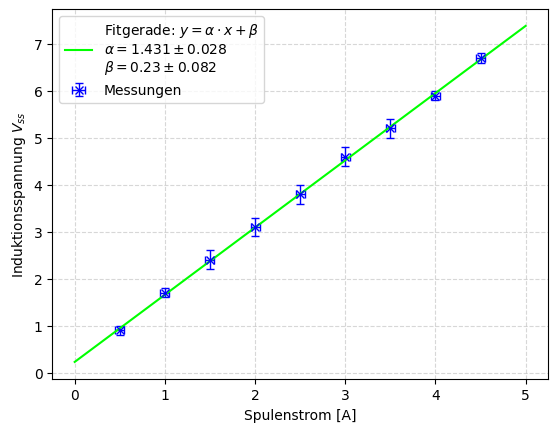

In [7]:
X = np.linspace(0, 5, 100)

plt.figure()
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(m2_I, m2_U, yerr=m2_dU, xerr=m2_dI, color='blue', fmt='x', label='Messungen', capsize=3, lw=1)
plt.plot(X, linfit(X, *m2_pop), color='lime', 
        label="\n".join([r"Fitgerade: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.3f}\pm{:.2}$'.format(m2_pop[0], np.sqrt(m2_cov[0][0])), 
                          r'$\beta ={:.2f}\pm{:.2}$'.format(m2_pop[1], np.sqrt(m2_cov[1][1]))]))
plt.xlabel('Spulenstrom [A]')
plt.ylabel(r'Induktionsspannung $V_{ss}$')
plt.legend()
plt.savefig('./plots/Induktionsgesetz_U(I).pdf', format='PDF')

In [8]:
m1_a = m1_pop[0]
m1_da = np.sqrt(m1_cov[0][0])

In [9]:
#Spuleneigenschaften:
d_H = 0.295 #m
r_H = 0.147 #m
N_H = 124

N_I = 4000
A_I = 41.7e-4 #m^2

In [10]:
B = m1_a /(4*np.pi*N_I*A_I)
dB = B * np.sqrt((m1_da/m1_a)**2)

print("|B| = ({} +/- {})T".format(B, dB))

|B| = (0.0036031678031685733 +/- 8.669353886843255e-05)T


In [11]:
#theoretischer Wert:
B_theo = const.mu_0 * 8 * N_H * m1_I /(np.sqrt(125)*r_H)
dB_theo = B_theo * np.sqrt((m1_dI/m1_I)**2)

print("|B|_theo = ({} +/- {})T".format(B_theo, dB_theo))

|B|_theo = (0.003033955359776194 +/- 7.584888399440485e-05)T


In [12]:
_ = sigma(B, B_theo, dB, dB_theo, 'B')

Sigmaabweichung B = 4.941493028235888


# Induktionsspannung bei periodischen Funktionen

## Winkelabhängigkeit

In [13]:
m3_alpha = np.array([0,30,60,90,120,150,180]) * np.pi/180 #°
m3_dalpha = np.full(7, 2.5) * np.pi/180

m3_U = np.array([1.3,1.09,0.58,0.14,0.75,1.18,1.2]) #V
m3_dU = np.array([0.05,0.05,0.010,0.010,0.010, 0.03,0.03])

m3_f = 100 #Hz

In [14]:
def abscos(x,a,bkg):
    return abs(N_I* A_I * a * 2 * np.pi * m3_f * np.cos(x)) + bkg

In [15]:
m3_pop, m3_cov = curve_fit(abscos, m3_alpha, m3_U, sigma=m3_dU)
m3_pop

array([1.04152931e-04, 1.30424324e-01])

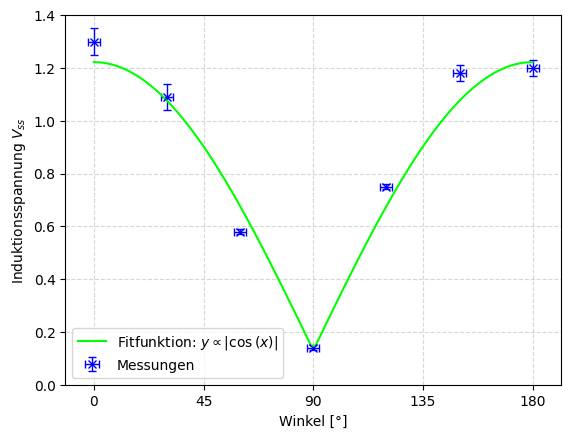

In [16]:
X = np.linspace(0, np.pi, 100)

plt.figure()
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(m3_alpha, m3_U, yerr=m3_dU, xerr=m3_dalpha, color='blue', fmt='x', label='Messungen', capsize=3, lw=1)
plt.plot(X, abscos(X, *m3_pop), color='lime', label=r"Fitfunktion: $y\propto |\cos{(x)}|$")
plt.xlabel('Winkel [°]')
plt.ylabel(r'Induktionsspannung $V_{ss}$')
plt.ylim([0,1.4])
plt.xticks(ticks=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], labels=[0, 45, 90, 135, 180])
plt.legend()
plt.savefig('./plots/Winkelabhängigkeit.pdf', format='PDF')

## Frequenzabhängigkeit

In [17]:
m4_f = np.array([20,40,60,80,100,120,140,161,180.5,201,400,600,801,1000,1200,1410,1610,1815,2010]) #Hz
m4_df = np.array([1,1,1,1,1,1,1,1,1,1,2,2,2,5,5,10,10,10,10])

m4_Ui = np.array([450,820,1050,1210,1300,1340,1390,1410,1440,1450,1500,1510,1520,1530,1540,1540,1540,1570,1590]) * 1e-3 #Vss
m4_dUi = np.array([30,10,30,30,30,20,20,20,20,20,20,20,20,10,10,10,10,10,10]) *1e-3

m4_Us = np.array([2360,2360,2330,2310,2300,2280,2270,2270,2250,2270,2270,2270,2270,2270,2270,2270,2270,2270,2270]) * 1e-3 #Vss
m4_dUs = np.array([30,30,30,30,30,10,10,10,10,10,10,10,10,10,10,10,10,10,10]) * 1e-3 #Vss

m4_Is = np.array([9340,8330,7180,6100,5280,4610,4070,3610,3263,2960,1546,1040,781,628,522,446,390,345,311]) * 1e-5 #A
m4_dIs = np.array([10,10,10,10,10,10,10,10,5,5,3,3,1,1,1,1,1,1,1]) * 1e-5

In [18]:
#Verhältnis spannungen:
m4_ratio = m4_Ui/m4_Us
m4_dratio = m4_ratio * np.sqrt((m4_dUi/m4_Ui)**2 + (m4_dUs/m4_Us)**2)

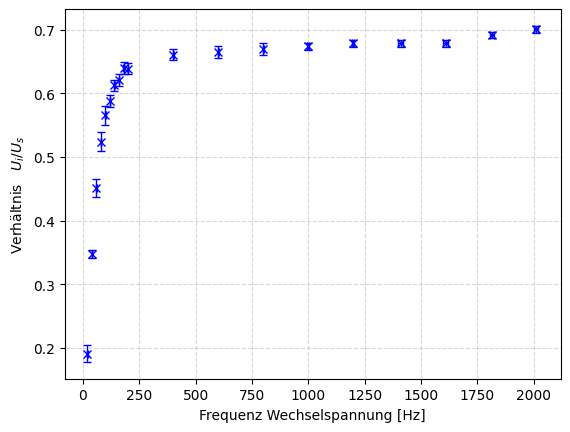

In [19]:
X = np.linspace(0, np.pi, 100)

plt.figure()
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(m4_f, m4_ratio, yerr=m4_dratio, xerr=m4_df, color='blue', fmt='x', label='Messungen', capsize=3, lw=1)
plt.xlabel('Frequenz Wechselspannung [Hz]')
plt.ylabel(r'Verhältnis   $U_i / U_s$')
#plt.legend()
plt.savefig('./plots/Wechselspannung-Frequenzabh.pdf', format='PDF')

In [20]:
#Widerstand:
m4_R = m4_Us / m4_Is
m4_dR = m4_R * np.sqrt((m4_dUs/m4_Us)**2 + (m4_dIs/m4_Is)**2)

In [21]:
#Fit:
m4_pop, m4_cov = curve_fit(linfit, m4_f, m4_R, sigma=m4_dR, absolute_sigma=True)

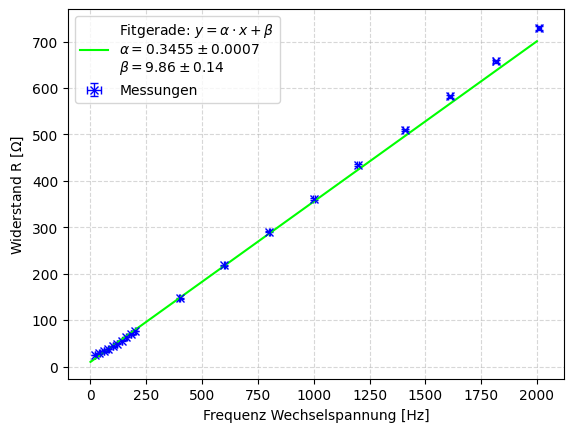

In [33]:
X = np.linspace(0, 2000, 100)

plt.figure()
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(m4_f, m4_R, yerr=m4_dR, xerr=m4_df, color='blue', fmt='x', label='Messungen', capsize=3, lw=1)
plt.plot(X, linfit(X, *m4_pop), color='lime', 
        label="\n".join([r"Fitgerade: $y = \alpha \cdot x + \beta$", 
                          r'$\alpha ={:.4}\pm{:.1}$'.format(m4_pop[0], np.sqrt(m4_cov[0][0])), 
                          r'$\beta ={:.3}\pm{:.2}$'.format(m4_pop[1], np.sqrt(m4_cov[1][1]))]))
plt.xlabel('Frequenz Wechselspannung [Hz]')
plt.ylabel(r'Widerstand R [$\Omega$]')
plt.legend()
plt.savefig('./plots/Widerstand-R(f).pdf', format='PDF')

In [23]:
#Induktivität: L=R/omega
L = m4_pop[0] /(2*np.pi)
dL = np.sqrt(m4_cov[0][0]) /(2*np.pi)

print("L = ({} +/- {})".format(L, dL))

L = (0.0549921127850497 +/- 0.00010415651915808319)


# Erdmagnetfeld

## Ohne Kompensation

In [24]:
m5_f = 14.9 #Kreisfreq.
m5_df = 0.1

m5_Ui = 0.146 #Vss
m5_dUi = 0.003

In [25]:
m5_B = m5_Ui /(m5_f * 4*np.pi*N_I*A_I)
m5_dB = m5_B * np.sqrt((m5_dUi/m5_Ui)**2 + (m5_df/m5_f)**2)

print("|B|_erde = ({} +/- {})T".format(m5_B, m5_dB))

|B|_erde = (4.6747746148215755e-05 +/- 1.0105096746287664e-06)T


In [26]:
#Literaturwerte von https://www.zamg.ac.at/cms/de/geophysik/produkte-und-services-1/online-deklinationsrechner
m5_Btheo = 48909.8e-9
i_lit = 65.2

Bv_lit = np.sin(np.radians(i_lit)) * m5_Btheo
Bh_lit = np.cos(np.radians(i_lit)) * m5_Btheo

_ = sigma(m5_B, m5_Btheo, m5_dB, 0, 'Erdmagnetfeld')

print(Bv_lit)
print(Bh_lit)

Sigmaabweichung Erdmagnetfeld = 2.1395676915003525
4.439921491954885e-05
2.051531746202603e-05


## Mit Kompensation

In [27]:
m6_f = 14.75 # Hz
m6_df = 0.2

m6_I = 49.6e-3 #A
m6_dI = 0.15e-3

m6_Ui = 83e-3 #V
m6_dUi = 1e-3

In [28]:
#Vertikalkomponente:
m6_Bv = const.mu_0 * 8 * N_H * m6_I /(np.sqrt(125)*r_H)
m6_dBv = m6_Bv * np.sqrt((m6_dI/m6_I)**2)

print("|B|_vertikal = ({} +/- {})T".format(m6_Bv, m6_dBv))

_ = sigma(m6_Bv, Bv_lit, m6_dBv, 0, 'vertikales Erdmagnetfeld')

|B|_vertikal = (3.762104646122481e-05 +/- 1.137733259916073e-07)T
Sigmaabweichung vertikales Erdmagnetfeld = 59.57607725051516


In [29]:
#Horizontalkomponente:
m6_Bh = m6_Ui /(m6_f * 4*np.pi*N_I*A_I)
m6_dBh = m6_Bh * np.sqrt((m6_dUi/m6_Ui)**2 + (m6_df/m6_f)**2)

print("|B|_horizontal = ({} +/- {})T".format(m6_Bh, m6_dBh))

_ = sigma(m6_Bh, Bh_lit, m6_dBh, 0, 'horizontales Erdmagnetfeld')

|B|_horizontal = (2.6846035598559758e-05 +/- 4.86953462725894e-07)T
Sigmaabweichung horizontales Erdmagnetfeld = 13.000663556421381


In [30]:
ä = m6_Bh/m5_B
dä = ä * np.sqrt((m6_dBh/m6_Bh)**2 + (m5_dB/m5_B)**2)

In [31]:
#Inklination:
i = np.arccos(ä)
di = dä /np.sqrt(1-ä**2)

print("Inklination i = ({} +/- {})°".format(np.degrees(i), np.degrees(di)))

Inklination i = (54.951163606155895 +/- 1.1341451360115098)°


In [32]:
_ = sigma(np.degrees(i), i_lit, np.degrees(di), 0, 'Inklination')

Sigmaabweichung Inklination = 9.036618038046322
